# Methodologies for image processing of radar remote sensing data #

## Lecture 10. Ice tracking

You have two TerraSAR-X images of the Kyagar glacier

Using the techniques learned in simulation part, you have to compute the glacier velocity at
different points.



In [1]:
#pip install rasterio


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#----Reading TerrSAR-X (intensity) images----

path = './'
filename1 = 'sigma0_TDXHH_2015-06-13.tif'
filename2 = 'sigma0_TDXHH_2015-06-24.tif'

# Reading images
with rasterio.open(path + filename1) as src1:
    sar_img1 = src1.read(1)  # Assuming it's a single-band image

with rasterio.open(path + filename2) as src2:
    sar_img2 = src2.read(1)  # Assuming it's a single-band image

# Image dimensions
dx, dy = sar_img1.shape  # Use shape to get dimensions

# Convert images to double precision and normalize to [0, 1]
sar_img1 = sar_img1.astype(np.float32) / 255.0
sar_img2 = sar_img2.astype(np.float32) / 255.0

/home/lahuang/working/seaiceTopo_env/lib/python3.10/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Warning 1: TIFFFetchNormalTag:Incorrect value for "RichTIFFIPTC"; tag ignored


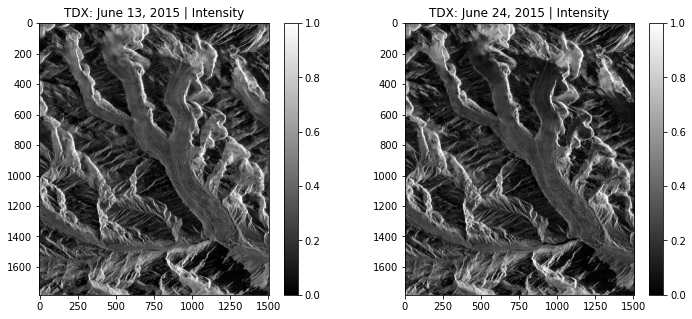

In [4]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first SAR image
axes[0].imshow(sar_img1, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('TDX: June 13, 2015 | Intensity')
axes[0].set_aspect('equal')
#axes[0].invert_yaxis()  # Invert the y-axis to match the 'set(gca, 'ydir', 'normal')' in MATLAB

# Plot the second SAR image
axes[1].imshow(sar_img2, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('TDX: June 24, 2015 | Intensity')
axes[1].set_aspect('equal')
#axes[1].invert_yaxis()

# Add colorbars to both subplots
cbar1 = fig.colorbar(axes[0].imshow(sar_img1, cmap='gray', vmin=0, vmax=1), ax=axes[0], orientation='vertical')
cbar2 = fig.colorbar(axes[1].imshow(sar_img2, cmap='gray', vmin=0, vmax=1), ax=axes[1], orientation='vertical')

plt.show()

In this below step:
We extract the image patches from sar_img1 and sar_img2 using NumPy array slicing.
We create a figure with 2x2 subplots using plt.subplots.
We plot the original SAR images in the top row with rectangles indicating the selected patches.
We plot the selected patches in the bottom row.


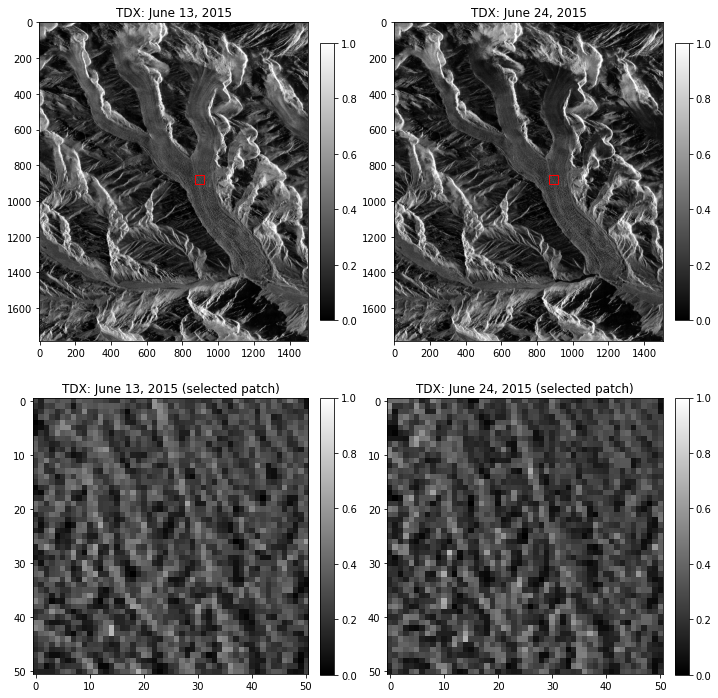

In [5]:
# Dimensions & position of the selected patches
coordinates_center = [879, 894]  # [row, column]
width = 51  # choose an odd number
height = 51  # choose an odd number

# Extracting image patches
patch_img1 = sar_img1[coordinates_center[0] - height // 2:coordinates_center[0] + height // 2 + 1,
                      coordinates_center[1] - width // 2:coordinates_center[1] + width // 2 + 1]
patch_img2 = sar_img2[coordinates_center[0] - height // 2:coordinates_center[0] + height // 2 + 1,
                      coordinates_center[1] - width // 2:coordinates_center[1] + width // 2 + 1]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the original SAR images
im1 = axes[0, 0].imshow(sar_img1, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('TDX: June 13, 2015')
axes[0, 0].set_aspect('equal')
axes[0, 0].add_patch(plt.Rectangle((coordinates_center[1] - width // 2, coordinates_center[0] - height // 2),
                                  width, height, edgecolor='r', facecolor='none'))

im2 = axes[0, 1].imshow(sar_img2, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('TDX: June 24, 2015')
axes[0, 1].set_aspect('equal')
axes[0, 1].add_patch(plt.Rectangle((coordinates_center[1] - width // 2, coordinates_center[0] - height // 2),
                                  width, height, edgecolor='r', facecolor='none'))

# Plot the selected patches
im3 = axes[1, 0].imshow(patch_img1, cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title('TDX: June 13, 2015 (selected patch)')
axes[1, 0].set_aspect('equal')

im4 = axes[1, 1].imshow(patch_img2, cmap='gray', vmin=0, vmax=1)
axes[1, 1].set_title('TDX: June 24, 2015 (selected patch)')
axes[1, 1].set_aspect('equal')

# Add colorbars to the subplots
cbar1 = fig.colorbar(im1, ax=axes[0, 0], orientation='vertical', fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(im2, ax=axes[0, 1], orientation='vertical', fraction=0.046, pad=0.04)
cbar3 = fig.colorbar(im3, ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
cbar4 = fig.colorbar(im4, ax=axes[1, 1], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()





The code below computes the cross-correlation between two patches, visualizes the spectra of both patches with colorbars, and displays the cross-correlation.

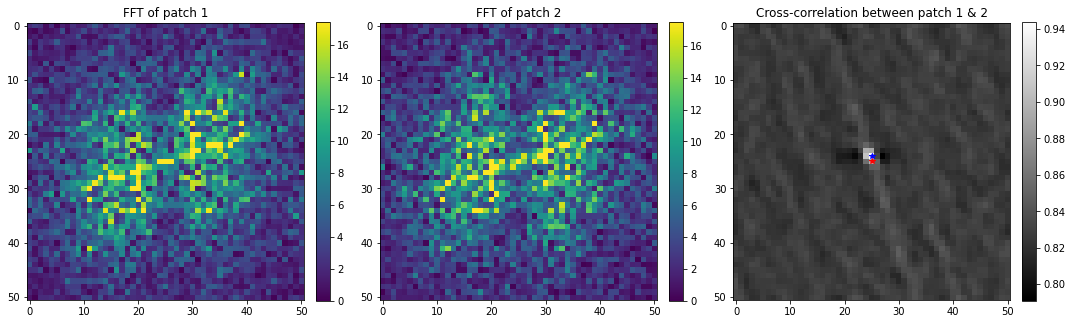

In [6]:
# FFT of the image patches
p1_spec = np.fft.fftshift(np.fft.fft2(patch_img1))
p2_spec = np.fft.fftshift(np.fft.fft2(patch_img2))

# Energy of the image patches
E1 = np.sum(patch_img1**2)
E2 = np.sum(patch_img2**2)

# Computing cross-correlation
prod = p1_spec * np.conj(p2_spec)
prodn = prod / np.sqrt(E1 * E2)
Corr = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(prodn))))

# Visualizing the spectra & cross-correlation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(np.abs(p1_spec), vmin=0, vmax=3.5 * np.mean(np.abs(p1_spec)))
axes[0].set_title('FFT of patch 1')
axes[0].set_aspect('equal')
cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(np.abs(p2_spec), vmin=0, vmax=3.5 * np.mean(np.abs(p2_spec)))
axes[1].set_title('FFT of patch 2')
axes[1].set_aspect('equal')
cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

im3 = axes[2].imshow(Corr, cmap='gray')
axes[2].set_title('Cross-correlation between patch 1 & 2')
axes[2].set_aspect('equal')
cbar3 = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# plot Center points of the patch
center_r = (patch_img1.shape[0]-1) / 2
center_c = (patch_img1.shape[1]-1) / 2
axes[2].plot(center_c, center_r, 'r*')

# Find the coordinates of the maximum value
max_value_coord = np.unravel_index(np.argmax(Corr), Corr.shape)
max_value_r, max_value_c = max_value_coord
axes[2].plot(max_value_c, max_value_r, 'b*')

plt.tight_layout()
plt.show()



The estimated displacement is 10.5 m.
The estimated speed is 0.9545454545454546 m/day.


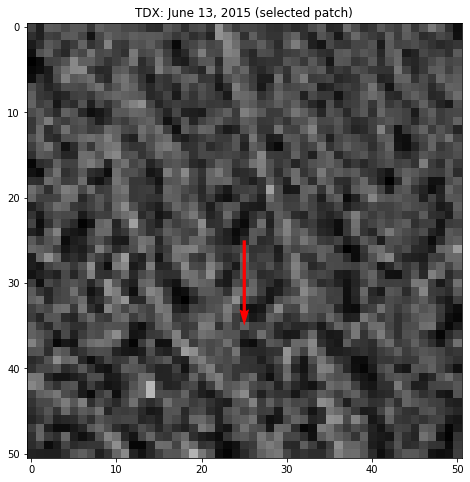

In [7]:
# Position of the peak of cross-correlation
peak_r, peak_c = np.unravel_index(np.argmax(Corr), Corr.shape)

# Shifts
shift_r =  (Corr.shape[0] - 1) / 2 - peak_r
shift_c = (Corr.shape[1] - 1) / 2 - peak_c

# Pixel dimensions
pd_r = 10.5  # in meters
pd_c = 10.0  # in meters

# Displacement
Displ = np.sqrt((shift_r * pd_r) ** 2 + (shift_c * pd_c) ** 2)
print(f'\nThe estimated displacement is {Displ} m.')

# Speed
TimeLapse = 11  # 11 days
speed = Displ / TimeLapse  # meters/day
print(f'The estimated speed is {speed} m/day.')

# Visualizing the direction of movement
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(patch_img1, cmap='gray', vmin=0, vmax=1)
ax.set_title('TDX: June 13, 2015 (selected patch)')
ax.axis('image')

# Drawing arrow
ax.quiver(center_c, center_r, 
          shift_c, shift_r, 
          angles='xy', scale_units='xy', 
          scale=0.1, 
          color='red')
plt.show()

Now, we want to estimate velocity over the glacier at various different points.
You can "slide" the patch windows and save the esimated velocity for each pair of patches.

As a first step, we write a function that (given the original images, the center coordinates of the desired patches, the width & height of the patches) provides you an estimate of the velocity. It should not draw any figures.


In [8]:
# FFT of the image patches
def estimate_velocity(patch_img1, patch_img2):

    p1_spec = np.fft.fftshift(np.fft.fft2(patch_img1))
    p2_spec = np.fft.fftshift(np.fft.fft2(patch_img2))
    E1 = np.sum(patch_img1**2)
    E2 = np.sum(patch_img2**2)

    prod = p1_spec * np.conj(p2_spec)
    prodn = prod / np.sqrt(E1 * E2)
    Corr = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(prodn))))

    # Center points of the patch
    center_r = (patch_img1.shape[0]-1) / 2
    center_c = (patch_img1.shape[1]-1) / 2

    # Position of the peak of cross-correlation
    peak_r, peak_c = np.unravel_index(np.argmax(Corr), Corr.shape)
    # Shifts
    # shift_r = peak_r - (Corr.shape[0] - 1) / 2
    # shift_c = peak_c - (Corr.shape[1] - 1) / 2
    shift_r = (Corr.shape[0] - 1) / 2 - peak_r
    shift_c = (Corr.shape[1] - 1) / 2 - peak_c

    # Pixel dimensions
    pd_r = 10.5  # in meters
    pd_c = 10.0  # in meters

    # Displacement
    Displ = np.sqrt((shift_r * pd_r) ** 2 + (shift_c * pd_c) ** 2)
    TimeLapse = 11  # 11 days
    speed = Displ / TimeLapse  # meters/day

    return speed, shift_r, shift_c

In [9]:
#"slide" the patch windows and save the esimated velocity for each pair of patches.
# Define parameters
delta_r = 25  # Jump along rows
delta_c = 25  # Jump along columns

start_r = 500-1
end_r = 1600-1
start_c = 300-1
end_c = 1200-1

nIterations_r = int(np.floor((end_r - start_r) / delta_r))
nIterations_c = int(np.floor((end_c - start_c) / delta_c))

speed_arr = np.zeros((nIterations_r, nIterations_c))
shift_arr_r = np.zeros((nIterations_r, nIterations_c))
shift_arr_c = np.zeros((nIterations_r, nIterations_c))
coordinates_center_r = np.zeros((nIterations_r, nIterations_c), dtype=int)
coordinates_center_c = np.zeros((nIterations_r, nIterations_c), dtype=int)

for j in range(nIterations_r):
    for k in range(nIterations_c):
        coordinates_center_r[j, k] = start_r + j * delta_r
        coordinates_center_c[j, k] = start_c + k * delta_c

        coordinates_center_i = [coordinates_center_r[j, k], coordinates_center_c[j, k]]

        width = 51  # choose an odd number
        height = 51  # choose an odd number

        # Extracting image patches
        patch_img1 = sar_img1[coordinates_center_i[0] - height // 2:coordinates_center_i[0] + height // 2 + 1,
                        coordinates_center_i[1] - width // 2:coordinates_center_i[1] + width // 2 + 1]
        patch_img2 = sar_img2[coordinates_center_i[0] - height // 2:coordinates_center_i[0] + height // 2 + 1,
                        coordinates_center_i[1] - width // 2:coordinates_center_i[1] + width // 2 + 1]


        #  Call your velocity estimation function here (replace with the actual function)
        speed, shift_r, shift_c = estimate_velocity(patch_img1, patch_img2)

        # Store results
        speed_arr[j, k] = speed
        shift_arr_r[j, k] = shift_r
        shift_arr_c[j, k] = shift_c

shift_arr_r[(shift_arr_r == 0) & (shift_arr_c == 0)] = np.nan
shift_arr_c[np.isnan(shift_arr_r)] = np.nan

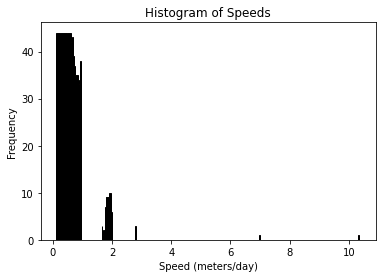

In [10]:
# Here you can check the result by plotting the histogram
plt.hist(speed_arr, bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Speeds')
plt.xlabel('Speed (meters/day)')
plt.ylabel('Frequency')
plt.show()

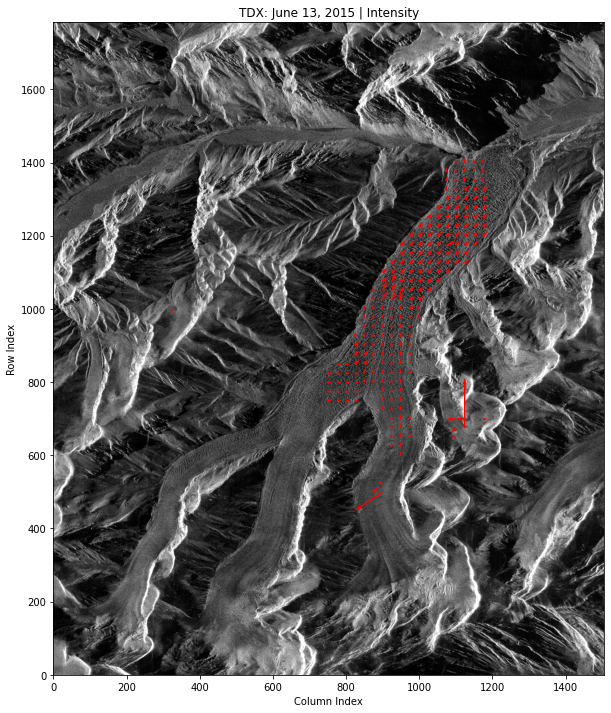

In [11]:
# Finally, we could create a figure and display the original image
plt.figure(figsize=(15, 12))
plt.imshow(sar_img1, cmap='gray')
plt.title('TDX: June 13, 2015 | Intensity')

# Add quiver plot to display velocity vectors
plt.quiver(
    coordinates_center_c,  # X-coordinates of vector positions
    coordinates_center_r,  # Y-coordinates of vector positions
    shift_arr_c,  # X-components of vectors
    shift_arr_r,  # Y-components of vectors
    color='r',  # Vector color
    angles='xy',  # Specify that angles are in 'xy' coordinates
    scale_units='xy',  # Specify that scale units are in 'xy' coordinates
    scale=0.08,  # Scale factor (set to 1 to match the specified length)
)

plt.ylim(0, 1783)  # Adjust the x-axis limits to fit the arrow
plt.xlim(0, 1505)  # Adjust the y-axis limits to fit the arrow
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [12]:
# # the largest error comes from patch, j=6 k=32, take a look of what happens on this pixel.
# j=7
# k=33
# coordinates_center_r[j, k] = start_r + j * delta_r
# coordinates_center_c[j, k] = start_c + k * delta_c

# coordinates_center_i = [coordinates_center_r[j, k], coordinates_center_c[j, k]]

# # Extracting image patches
# patch_img1 = sar_img1[coordinates_center_i[0] - height // 2:coordinates_center_i[0] + height // 2 + 1,
#                 coordinates_center_i[1] - width // 2:coordinates_center_i[1] + width // 2 + 1]
# patch_img2 = sar_img2[coordinates_center_i[0] - height // 2:coordinates_center_i[0] + height // 2 + 1,
#                 coordinates_center_i[1] - width // 2:coordinates_center_i[1] + width // 2 + 1]

# speed, shift_r, shift_c = estimate_velocity(patch_img1, patch_img2)
# print('speed:', speed) #meters/day

# # FFT of the image patches
# p1_spec = np.fft.fftshift(np.fft.fft2(patch_img1))
# p2_spec = np.fft.fftshift(np.fft.fft2(patch_img2))

# # Energy of the image patches
# E1 = np.sum(patch_img1**2)
# E2 = np.sum(patch_img2**2)

# # Computing cross-correlation
# prod = p1_spec * np.conj(p2_spec)
# prodn = prod / np.sqrt(E1 * E2)
# Corr = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(prodn))))

# # Visualizing the spectra & cross-correlation
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# im1 = axes[0].imshow(np.abs(p1_spec), vmin=0, vmax=3.5 * np.mean(np.abs(p1_spec)))
# axes[0].set_title('FFT of patch 1')
# axes[0].set_aspect('equal')
# cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# im2 = axes[1].imshow(np.abs(p2_spec), vmin=0, vmax=3.5 * np.mean(np.abs(p2_spec)))
# axes[1].set_title('FFT of patch 2')
# axes[1].set_aspect('equal')
# cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# im3 = axes[2].imshow(Corr, cmap='gray')
# axes[2].set_title('Cross-correlation between patch 1 & 2')
# axes[2].set_aspect('equal')
# cbar3 = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# # Center points of the patch
# center_r = (patch_img1.shape[0]-1) / 2
# center_c = (patch_img1.shape[1]-1) / 2
# axes[2].plot(center_c, center_r, 'r*')

# # Find the coordinates of the maximum value
# max_value_coord = np.unravel_index(np.argmax(Corr), Corr.shape)
# max_value_r, max_value_c = max_value_coord
# axes[2].plot(max_value_c, max_value_r, 'b*') # you see the location of the blue points is inrational, this indicates the Cross-correlation method is not accurate for this pixel

# plt.tight_layout()
# plt.show()